# Simulate Ghosting

In [1]:
import BrukerMRI as bruker
import pylab as pl
import plot
#Python method of extracting raw Bruker Files
import BrukerMRI as bruker

# Modules
import pandas as pd
import pydicom as dcm
import math
import numpy as np
import matplotlib.pyplot as plt
import glob
from os.path import expanduser
import os
from matplotlib import cm
import cmath
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [2]:
# copy and paste entire directory but replace "\" with "/"
# Place a "/" at the end of the line
MainDir = "C:/Users/daniala/Desktop/mri/20191210_104049_MRMD_phantom_practice_1_3/"
ExpNum = 8
Experiment = bruker.ReadExperiment(MainDir, ExpNum)
acqp = Experiment.acqp
method = Experiment.method
raw_fid = Experiment.raw_fid
k_space_gen = Experiment.GenerateKspace()
k_space = Experiment.k_data
k_sp = bruker.phase_shift(120,0,k_space)[:,:,0]

## Effects of Zero Masks

In [3]:
def zero_mask(x,y,k_sp):
    row = k_sp.shape[0]
    col = k_sp.shape[1]
    k_sp2 = k_sp.copy()
    new_k = np.ones((row,col))
    v_mask = np.zeros((row,col))
    
    if x > 0:
        for i in range(0,col-1,x):
            v_mask[i,:] = new_k[i,:]
    if y > 0:         
       for i in range(0,col-1,y):
           v_mask[:,i] = new_k[:,i]

    return v_mask

In [4]:
# Masks with 0 in every odd line
mv_2 =  zero_mask(2,0,k_sp)
mh_2 =  zero_mask(0,2,k_sp)
mhv_2 =  zero_mask(2,2,k_sp)

## Multiplying the Masks with K-space

In [5]:
gv_2 =  np.multiply(k_sp,mv_2)
gh_2 =  np.multiply(k_sp,mh_2)
ghv_2 = np.multiply(k_sp,mhv_2)

### Visualisation of Mask in Image Space

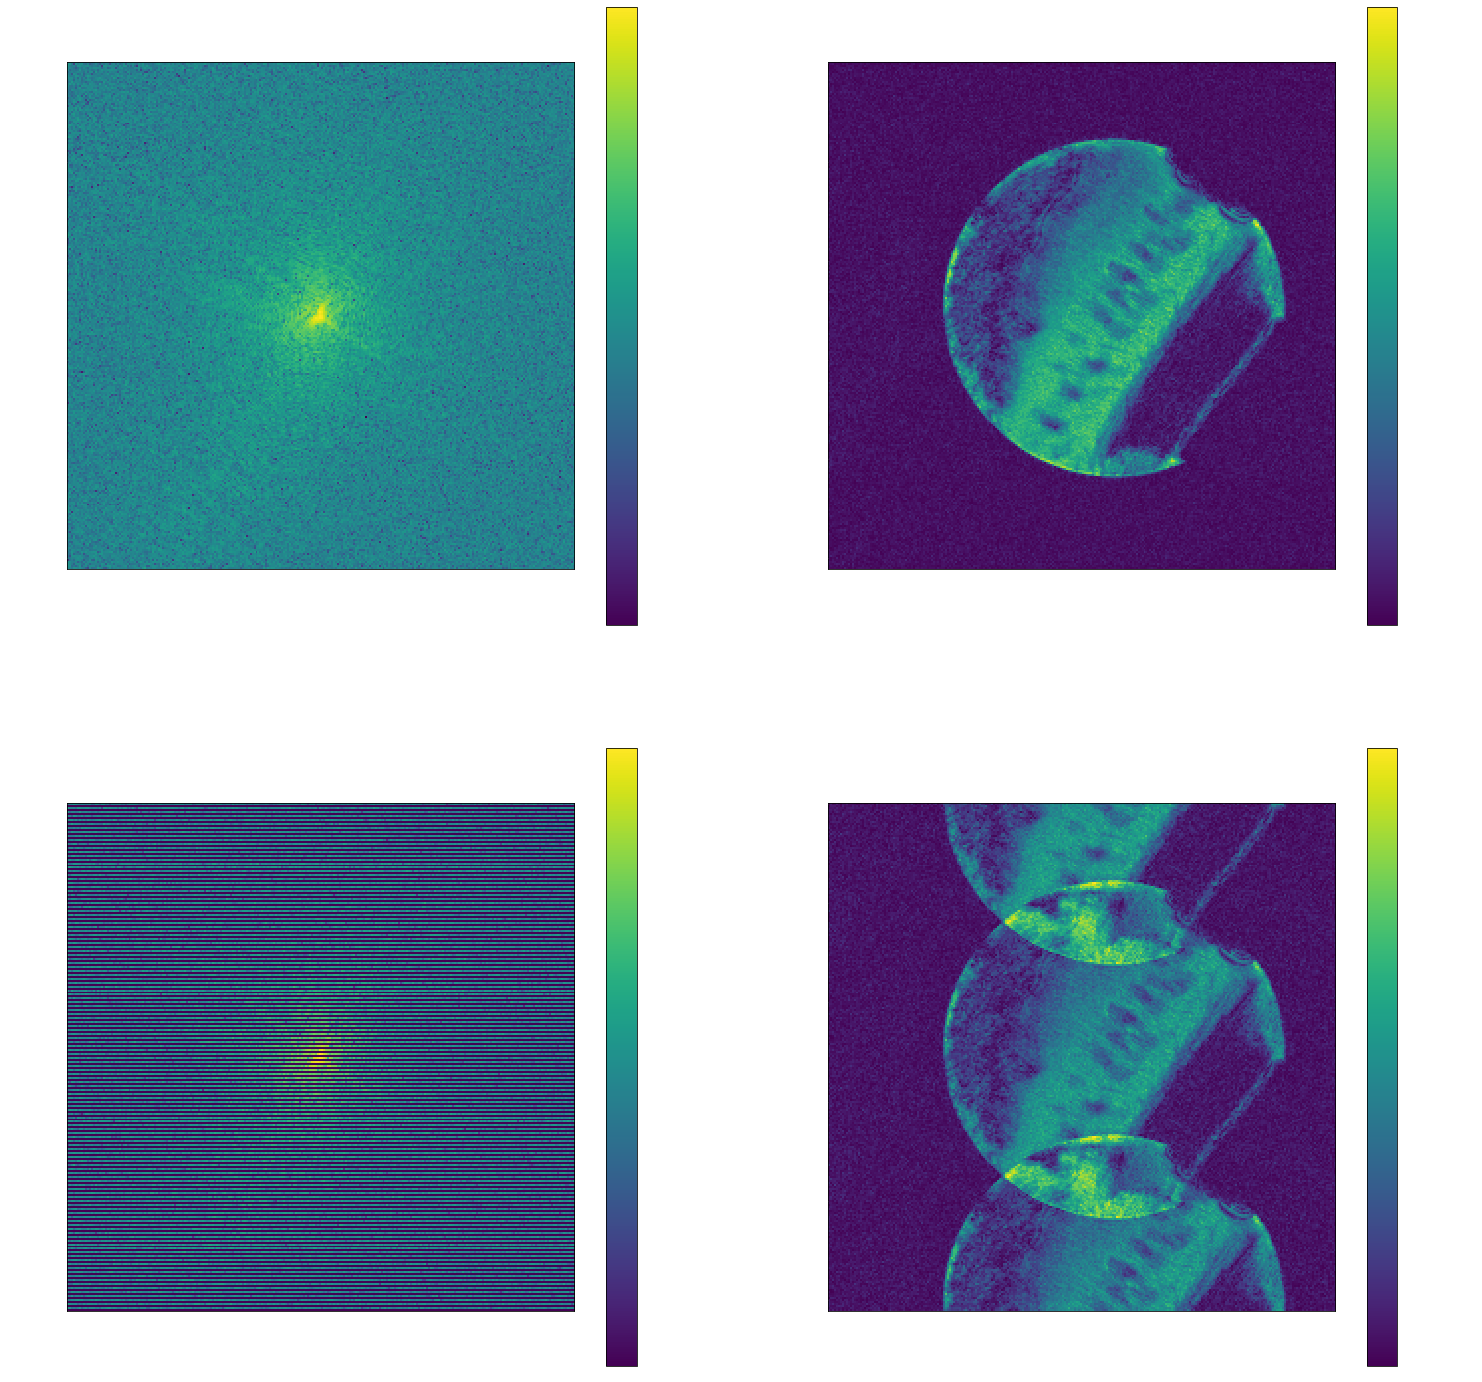

In [6]:
k_spaces = {'Original k-space':k_sp,
            'Masked every 2 Lines, Horizontal': gv_2
           }
plot.comparison_k_plots(k_spaces)

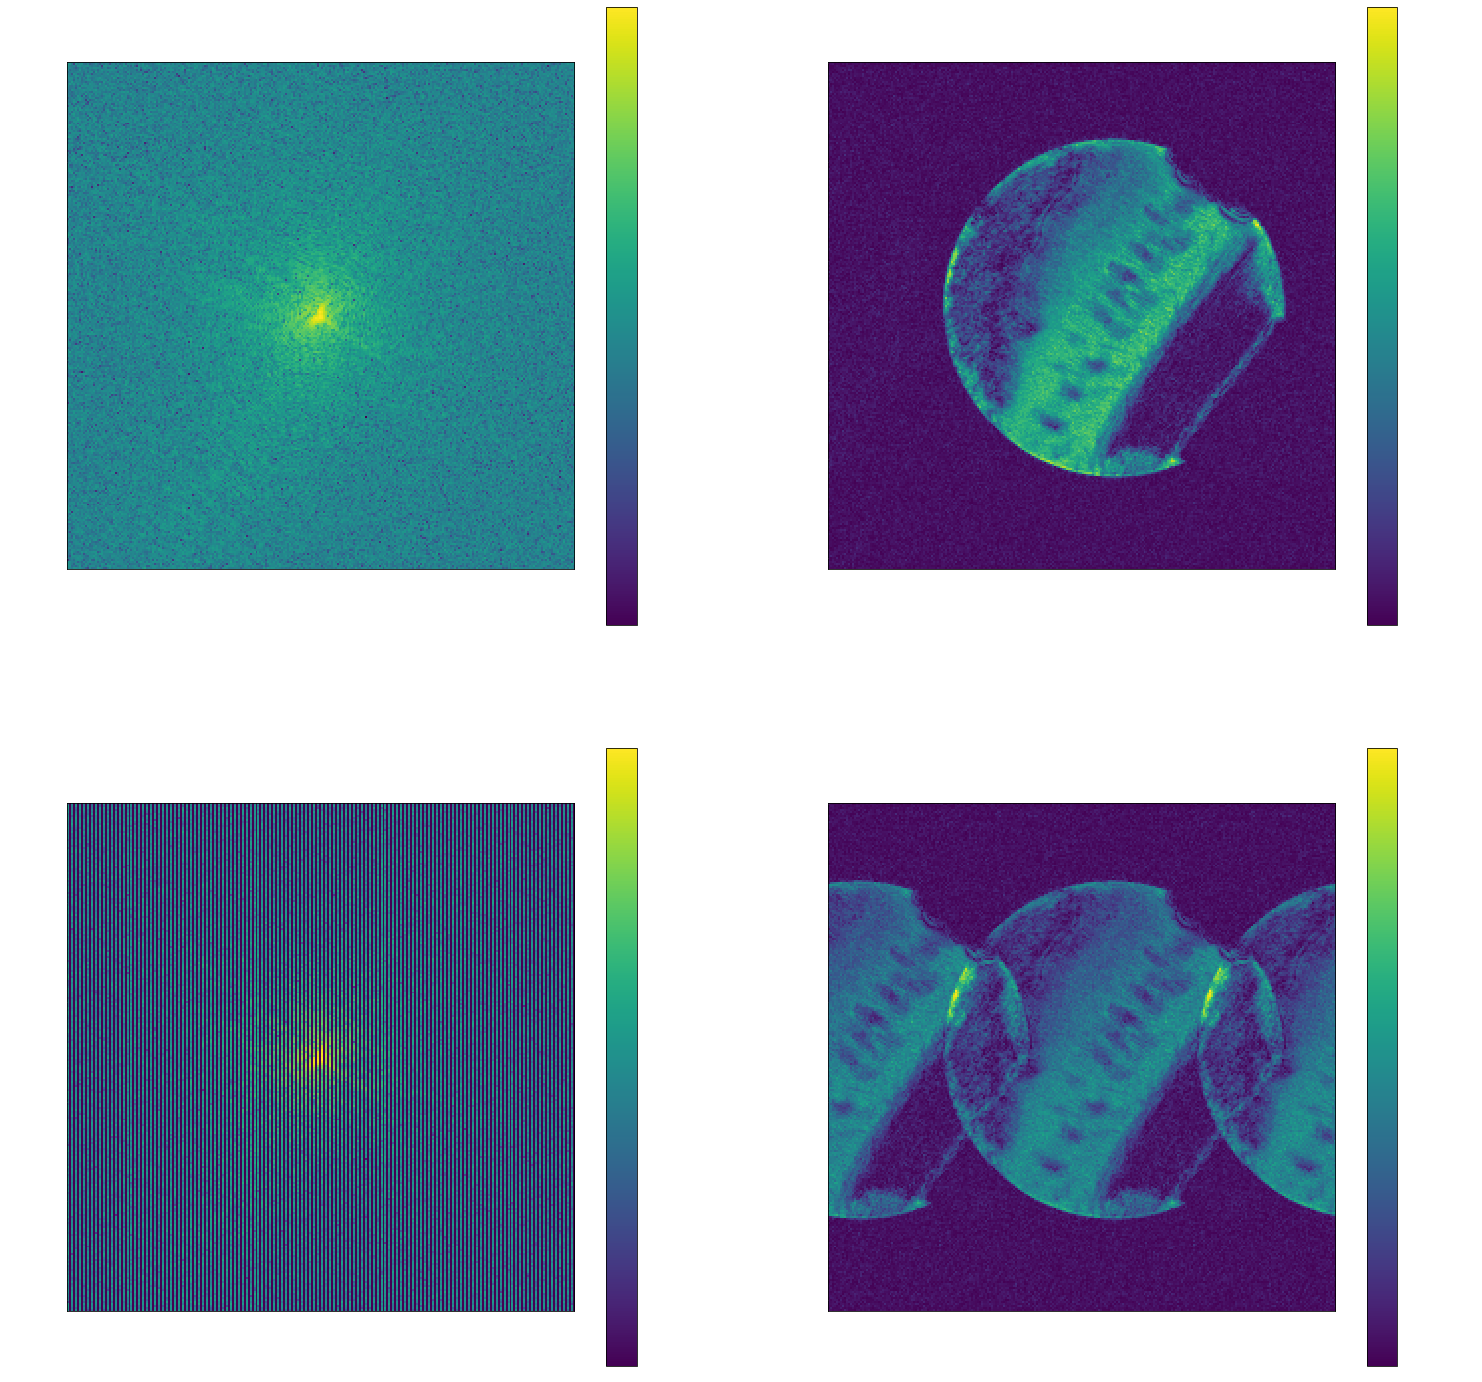

In [7]:
k_spaces2 = {'Original k-space':k_sp,
            'Masked every 2 Lines, Vertical': gh_2,
            }
plot.comparison_k_plots(k_spaces2)

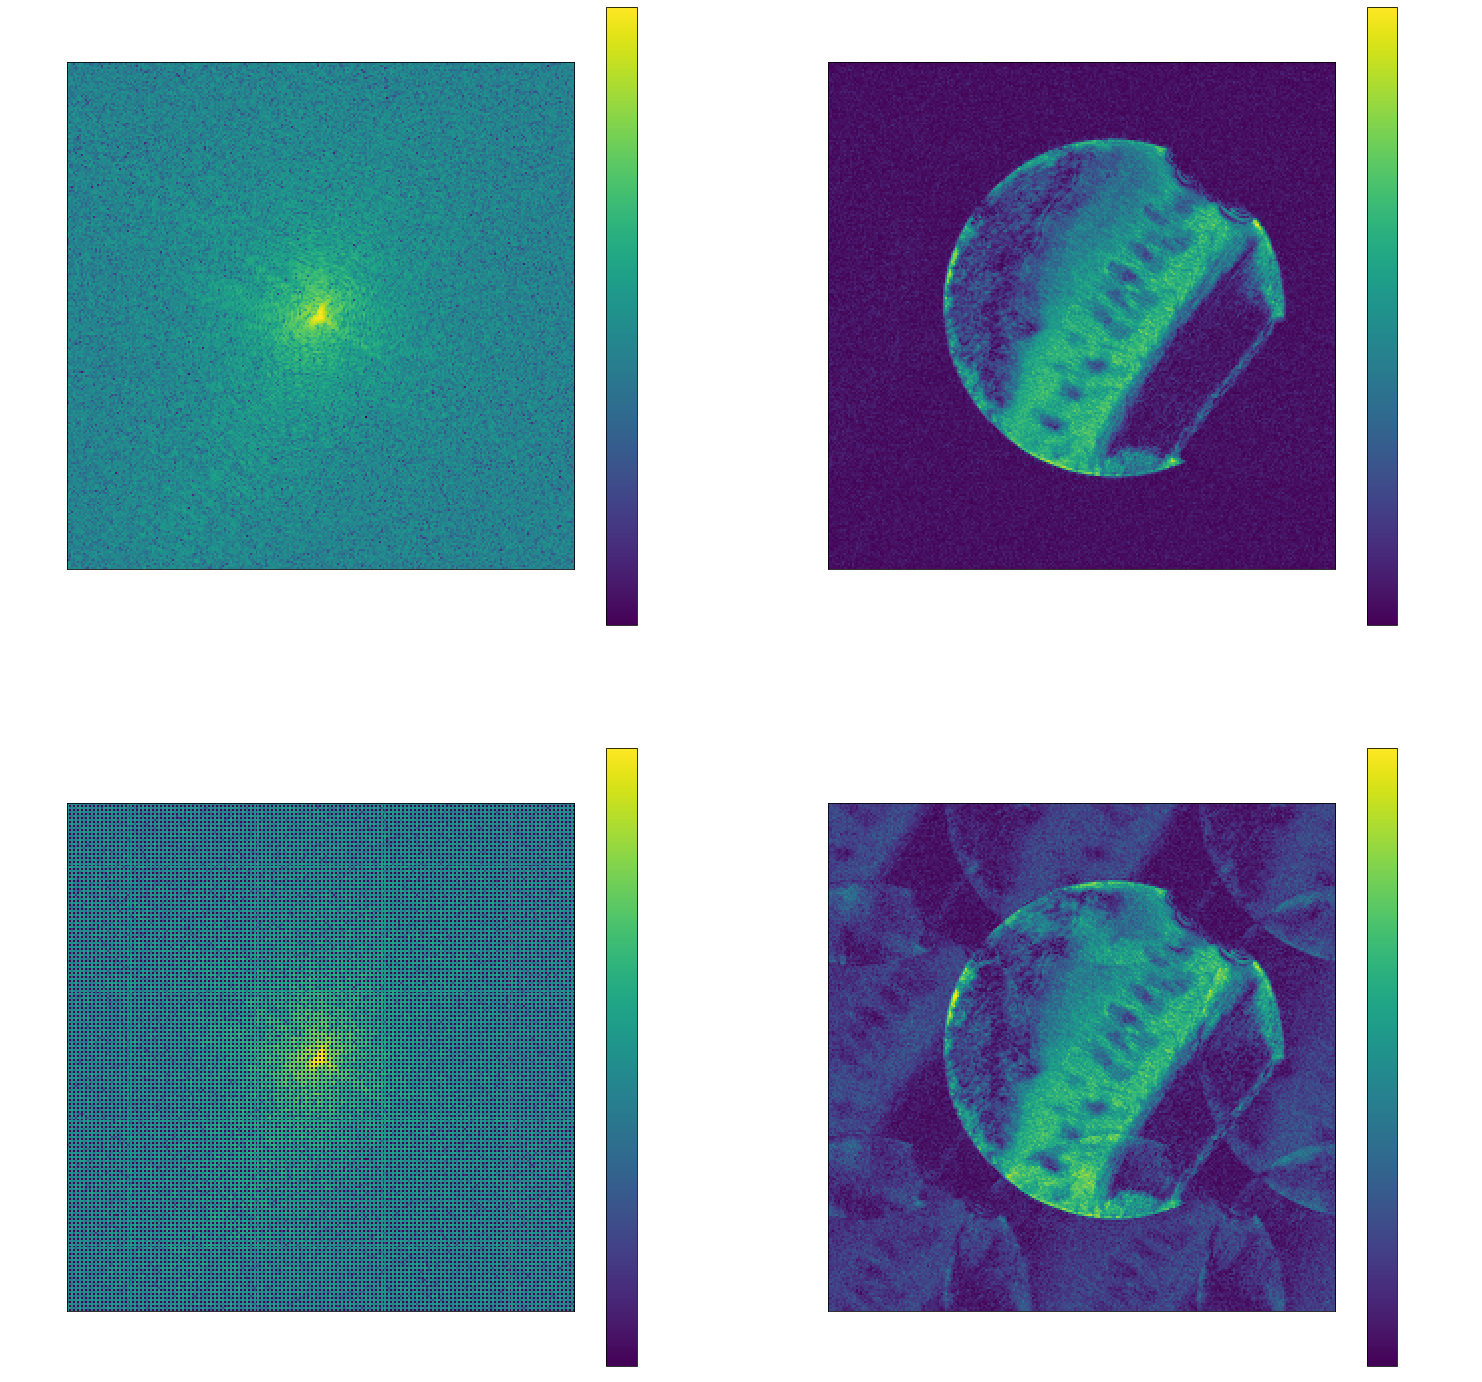

In [8]:
k_spaces3 = {'Original k-space':k_sp,
            'Masked every 2 Lines,Both': ghv_2
            }
plot.comparison_k_plots(k_spaces3) 

Applying Zero masks on the original k-spaces produces foldover and 'aliasing'similar to the reduction in the FOV images produced.
The images however are enlarged versions of those images similar to zero filling.

Zero-filling is when k-space is increased by adding regions with no information or in other words add k-space regions with zeros to it (Figure 5). The zeros neither contain signal nor contain noise. This simply increases the smoothness of the image and increases the signal to noise ratio (SNR). The SNR is reduced as the lines have zeros, which means it has comparatively less noise than actually measured noise. This is mainly used for decreasing scanning time and decreases sizes of the pixels. Thus, the scanned imaged matrix is usually smaller as the reconstruction matrix. The ratio between their sizes is referred to the scan percentage. 

## Shifting the Centre of K-space (Alternate Lines)

Nyquist N/2 Ghost. It occurs with echo-planar imaging sequences that have a zig-zag trajectory through k-space. In head MRI it is sometimes referred to as the "Three Brains Artifact". 
EPI pulse sequences are composed of a train of echoes, one echo generated for each line of k-space traversed. In zig-zag acquisition, every second echo is acquired in an alternate direction. For image reconstruction, even numbered echoes must be time-reversed so that match the odd numbered echoes before Fourier transformation.  
 
Nyquist N/2 Ghost Artifact
If the forward and backward echoes are not perfect mirror images of each other, then artifacts are introduced into the image processing. Even a simple delay of the start of the first echo will be propagated into all later echoes resulting in slight timing differences between the peaks of odd- and even-numbered echoes. 

When the Fourier transform is performed, this phase error results in signal intensity displaced in the phase-encode direction halfway across the image. If there are N pixels across the FOV, this aliased ghost appears shifted N/2 pixels relative to the main image positioned at the correct location. 

### Function that Rotates the order of k-Space

In [13]:
def roll_k(k_sp,shift_x):
    
    k_r = k_sp.copy()
    row = k_r.shape[0]
    col = k_r.shape[1]
    
    for i in range(0,row,2):
        temp = k_r[i,0:shift_x]
        for j in range(0,col-shift_x):
            k_r[i,j-shift_x] = k_r[i,j]
        k_r[i,col-shift_x:col] = temp
    return k_r

def roll_k_y(k_sp,shift_x):
    
    k_r = k_sp.copy()
    row = k_r.shape[0]
    col = k_r.shape[1]
    
    for i in range(0,row,2):
        temp = k_r[0:shift_x,i]
        for j in range(0,col-shift_x):
            k_r[j-shift_x,i] = k_r[j,i]
        k_r[col-shift_x:col,i] = temp
    return k_r

In [14]:
x_1 = roll_k(k_sp,1)
x_2 = roll_k(k_sp,2)
x_4 = roll_k(k_sp,4)

y_1 = roll_k_y(k_sp,1)
y_2 = roll_k_y(k_sp,2)
y_4 = roll_k_y(k_sp,4)

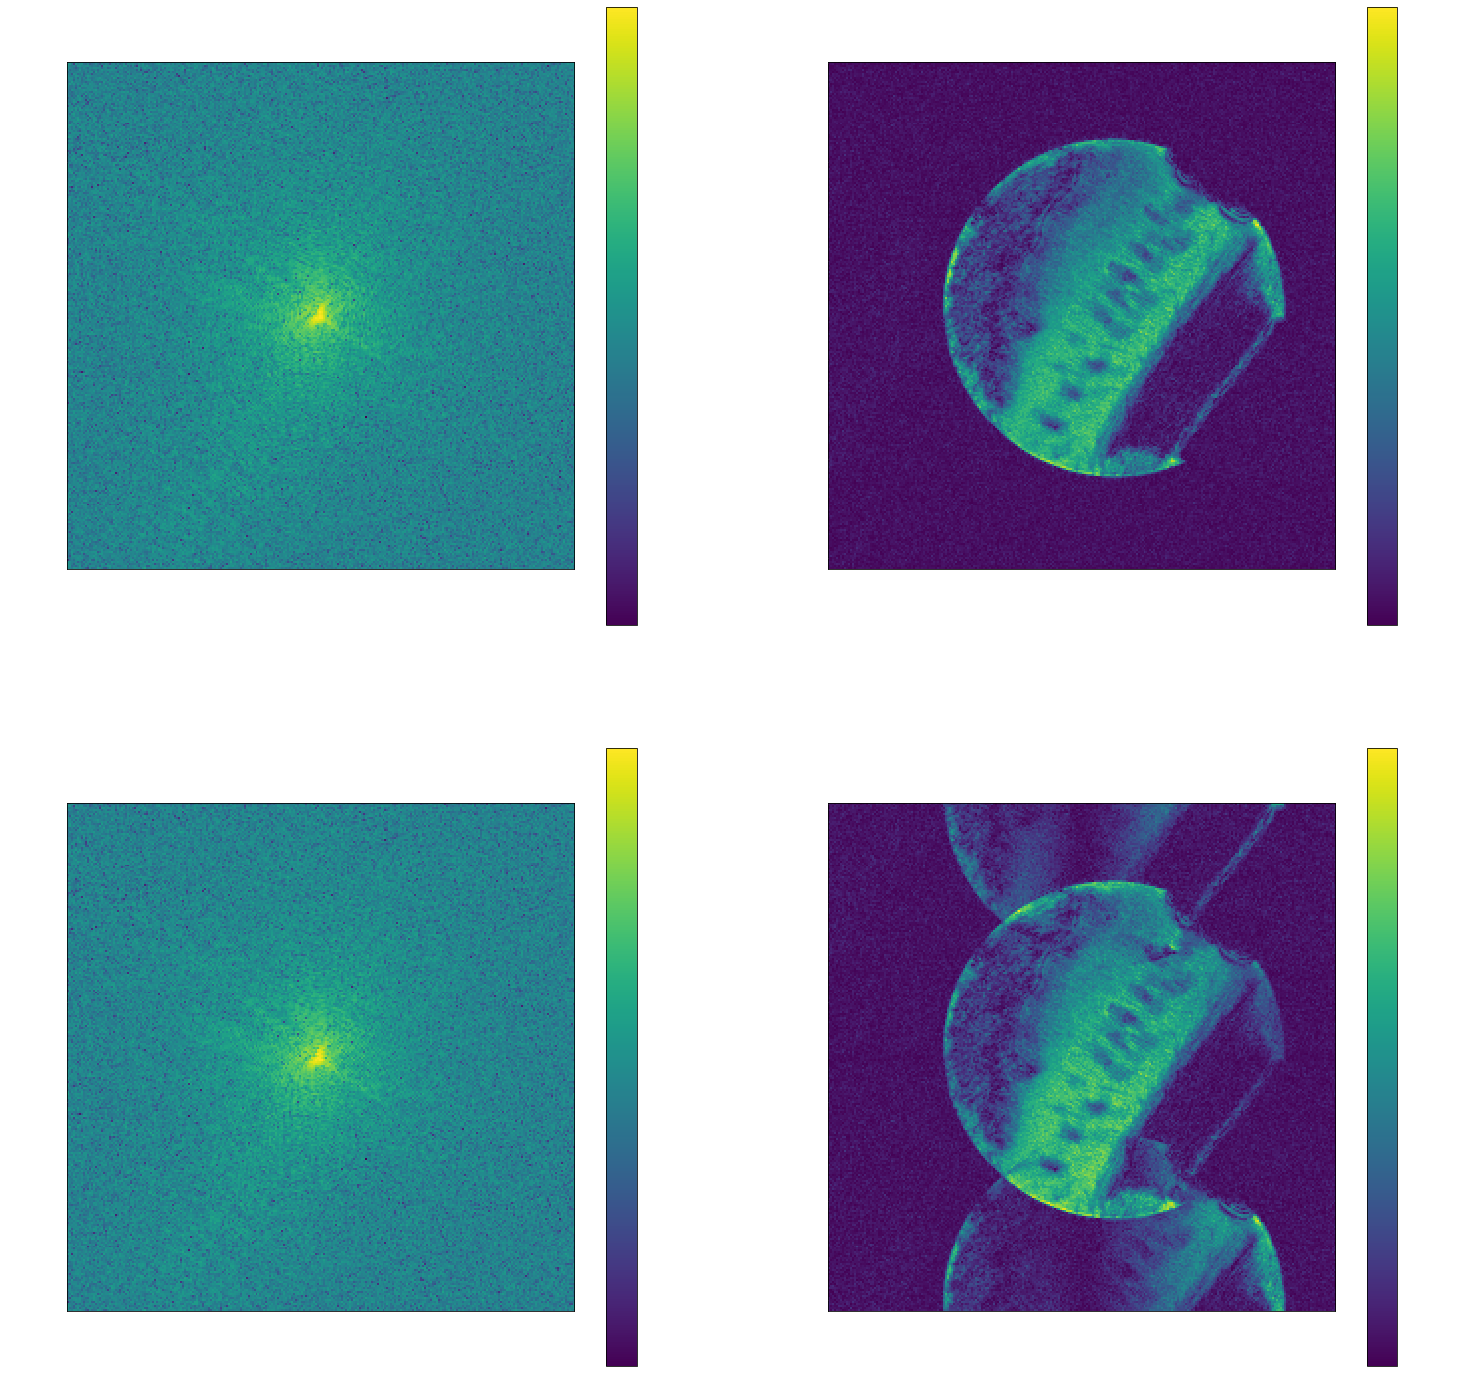

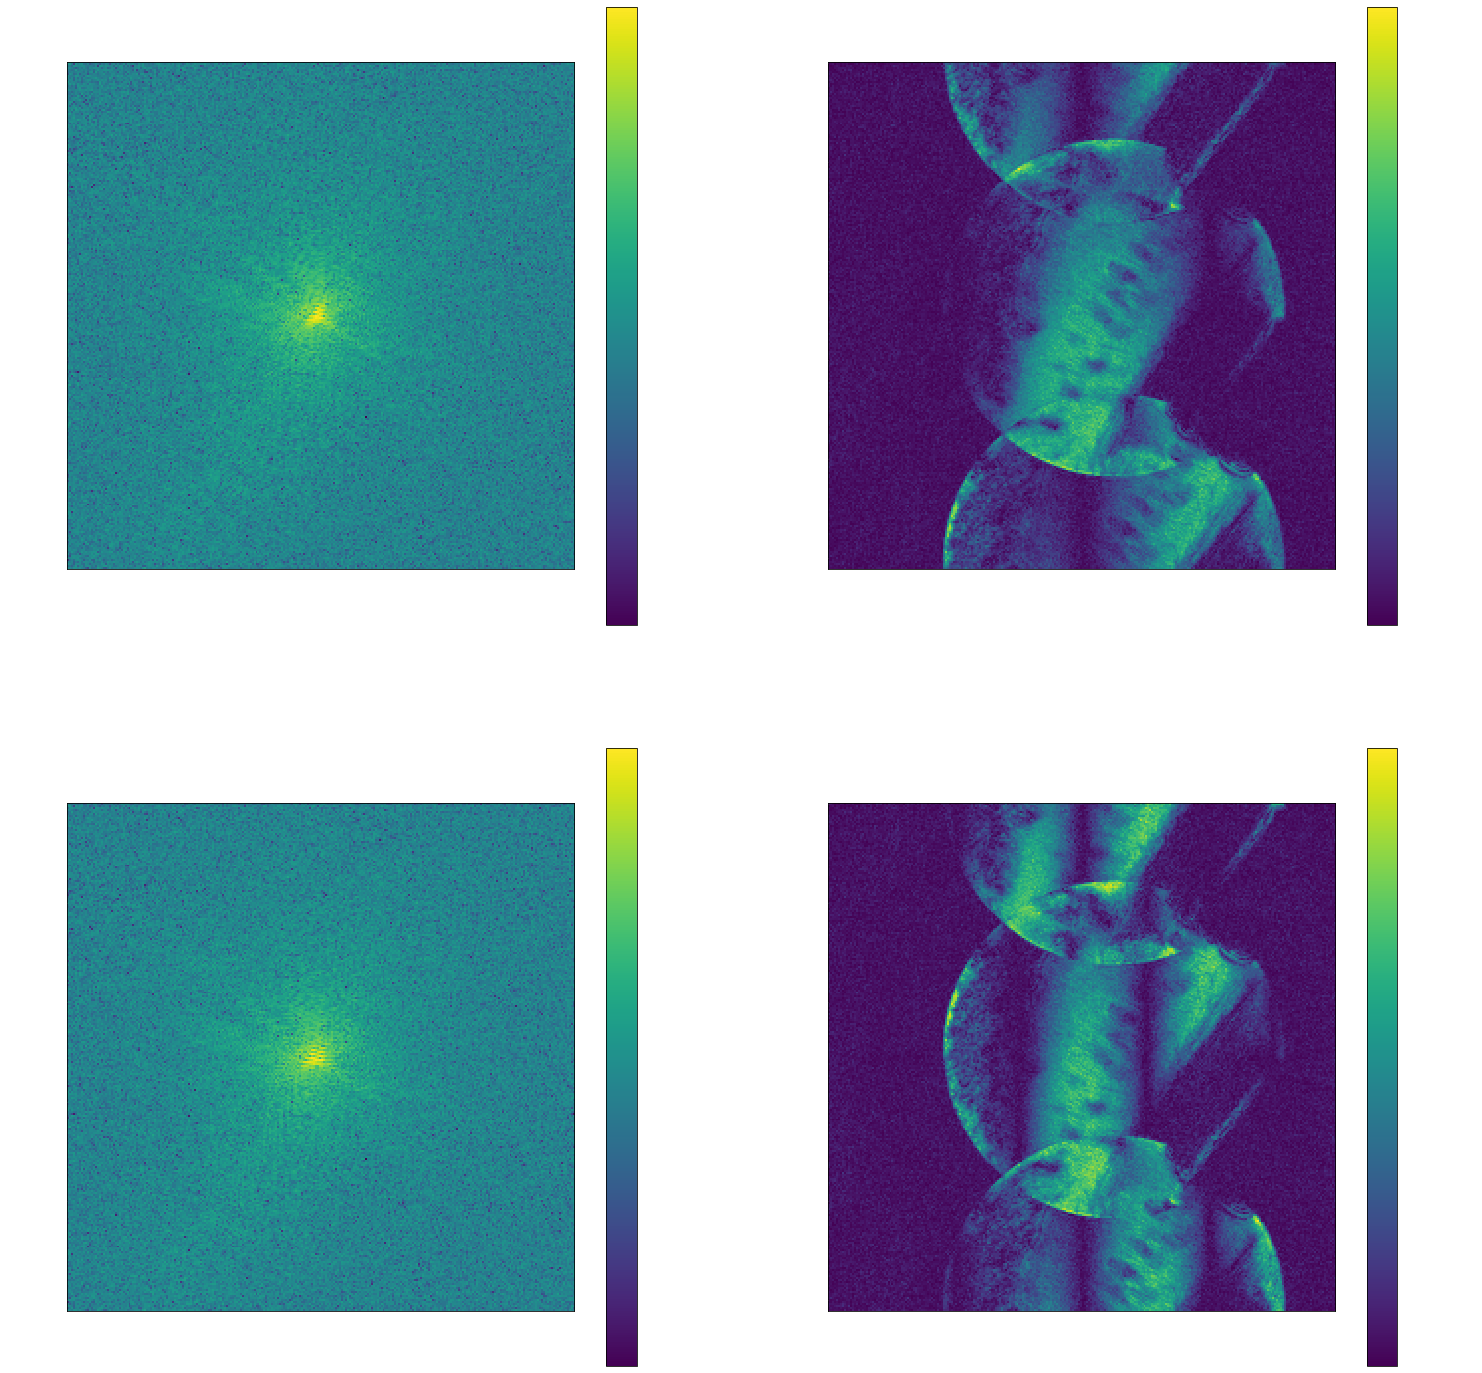

In [15]:
NG = {'Original k-space':k_sp,
    'Nyquist Ghost due to K-space shift in X by 1': x_1
}
NG2 = { 'Nyquist Ghost due to K-space shift in X by 2': x_2,
        'Nyquist Ghost due to K-space shift in X by 4': x_4
       }
plot.comparison_k_plots(NG)
plot.comparison_k_plots(NG2)

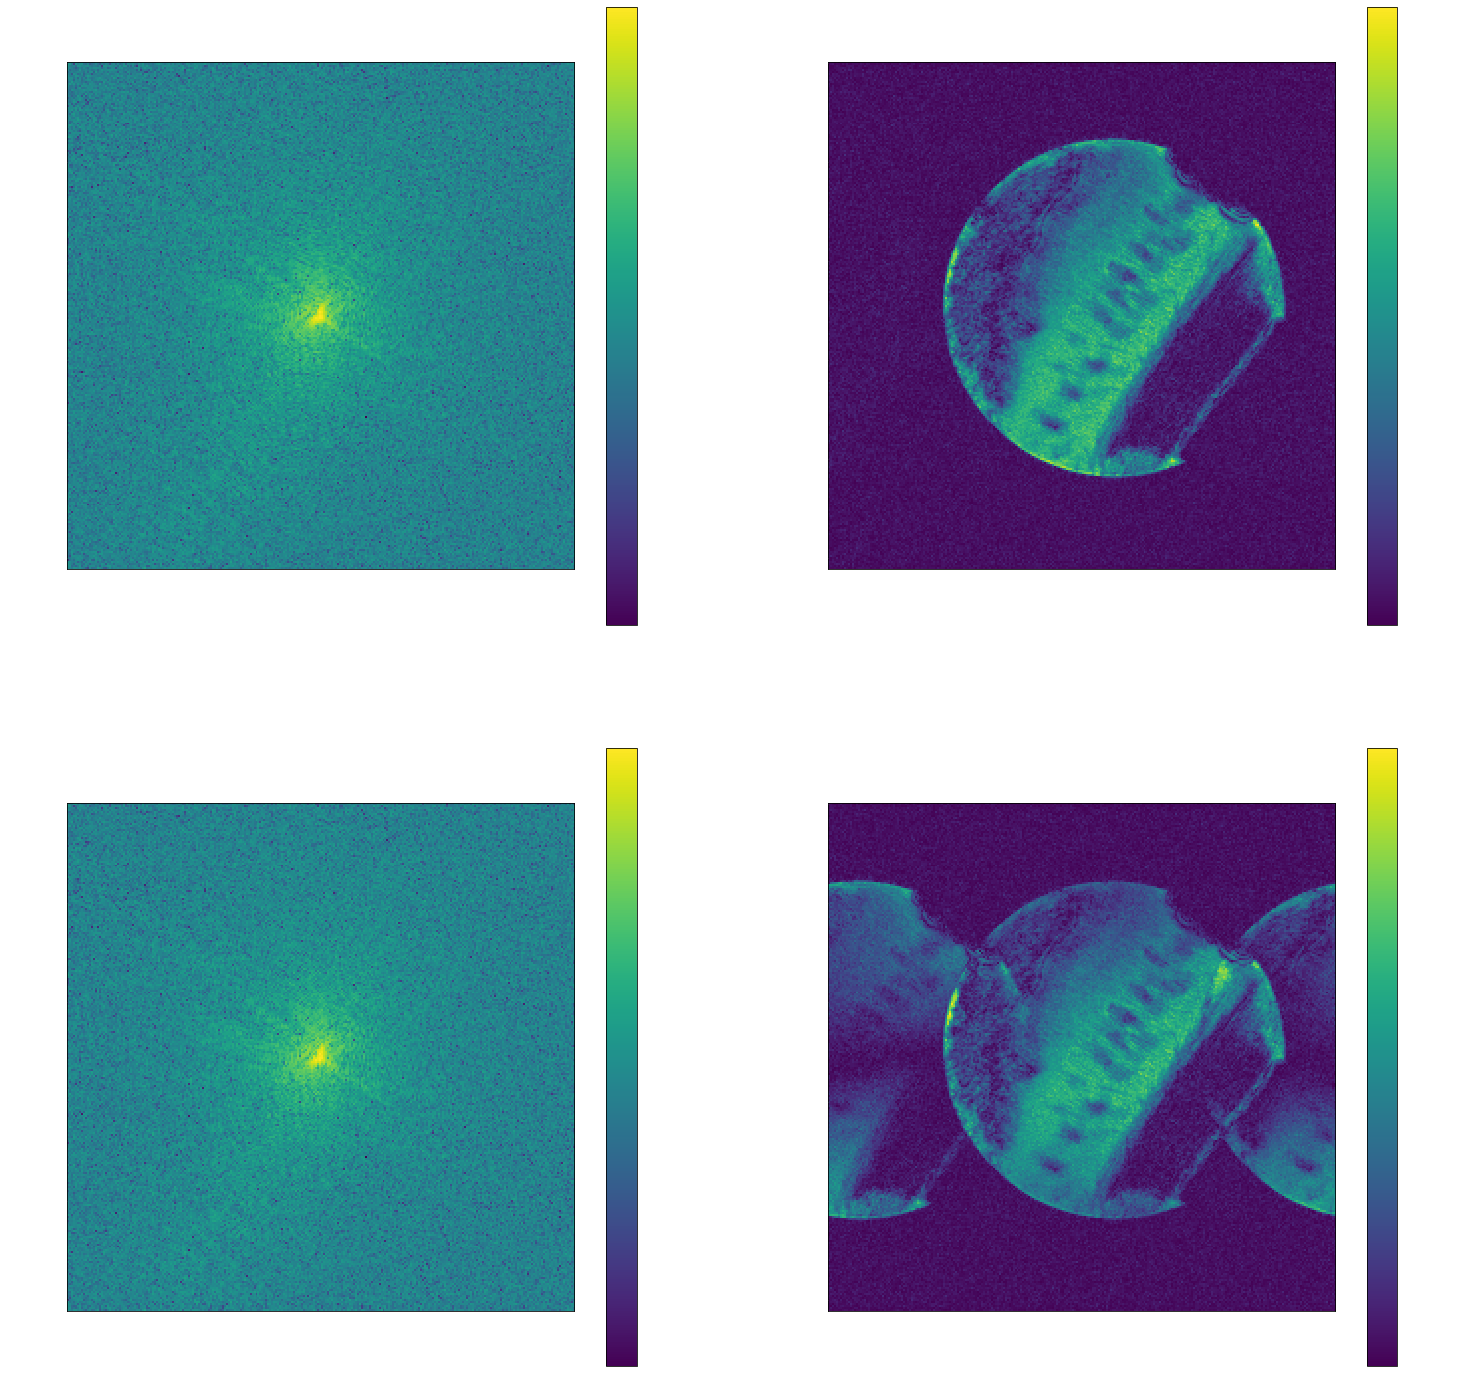

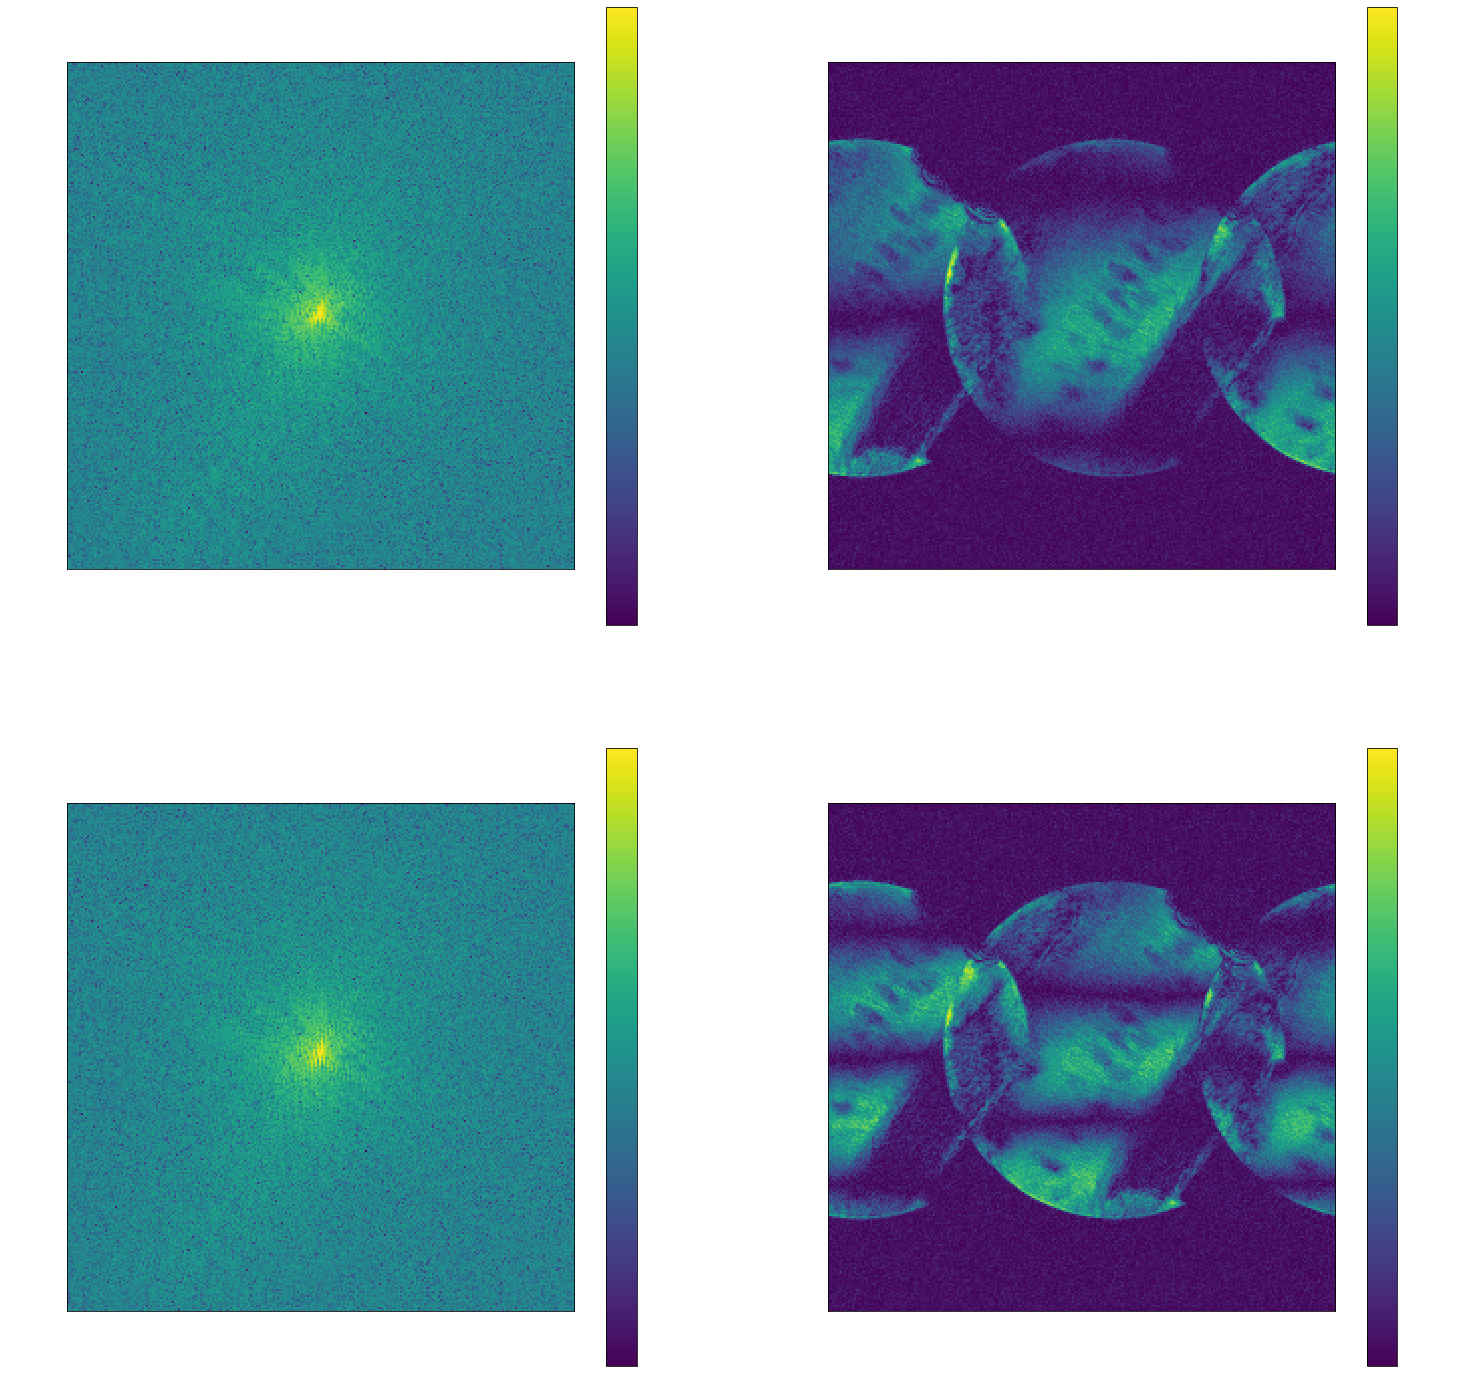

In [16]:
NG = {'Original k-space':k_sp,
    'Nyquist Ghost due to K-space shift in X by 1': y_1
}
NG2 = { 'Nyquist Ghost due to K-space shift in X by 2': y_2,
        'Nyquist Ghost due to K-space shift in X by 4': y_4
       }
plot.comparison_k_plots(NG)
plot.comparison_k_plots(NG2)

### Explanation to Modulation Phenomena

Assuming each line of k-space is a sin function with a shift of 0.1 per line.
The roll function shifts k-space using A PHASE SHIFT.
The superposition of each line of k-space given this phase shift in alternate lines causes a sin function modulation as the waves constructively and destructively interfere.

#### Superposition of 2 Lines of Sin Curve after Phase Shift

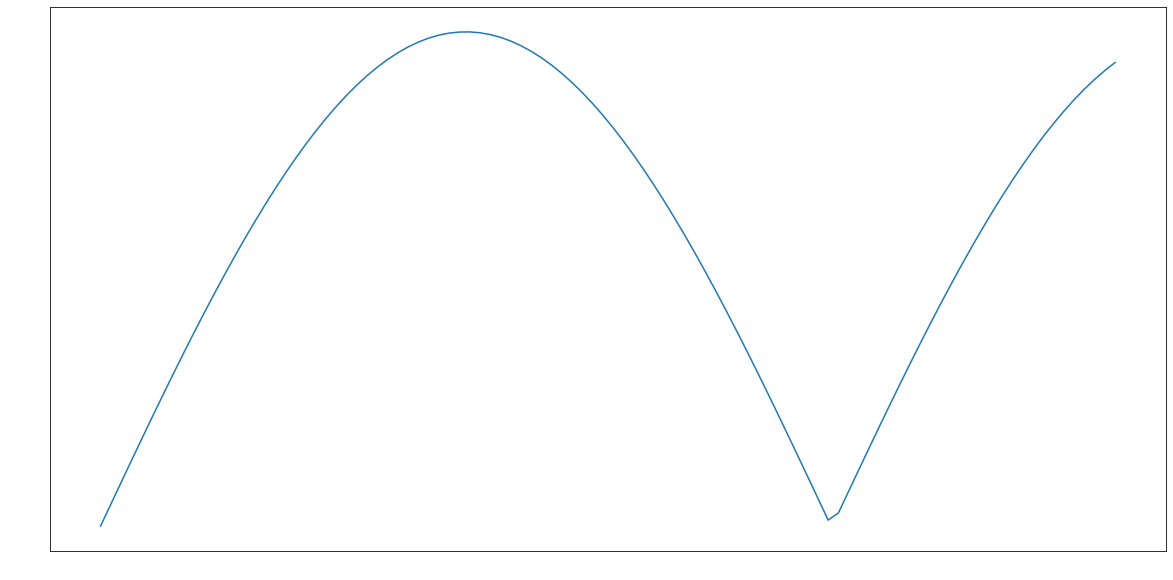

In [88]:
x=np.array(range(5000))
freq=1
shift_x = 0.5
amp=np.zeros(100)
for i in range(100):
    freq_i = freq
    shift = shift_x+8*i
    y1=np.sin(freq_i*x/100)
    y2=np.sin((freq_i+0.1)*(x+shift)/100)
    y2_unchanged=np.sin((freq_i+0.1)*x/100)
    y_change = (y1+y2)-(y1+y2_unchanged)
    amp[i]=max(y_change)
    

plt.figure(figsize=(20,10))
plt.plot(np.array(range(100)),amp)

### Superposition of Waves

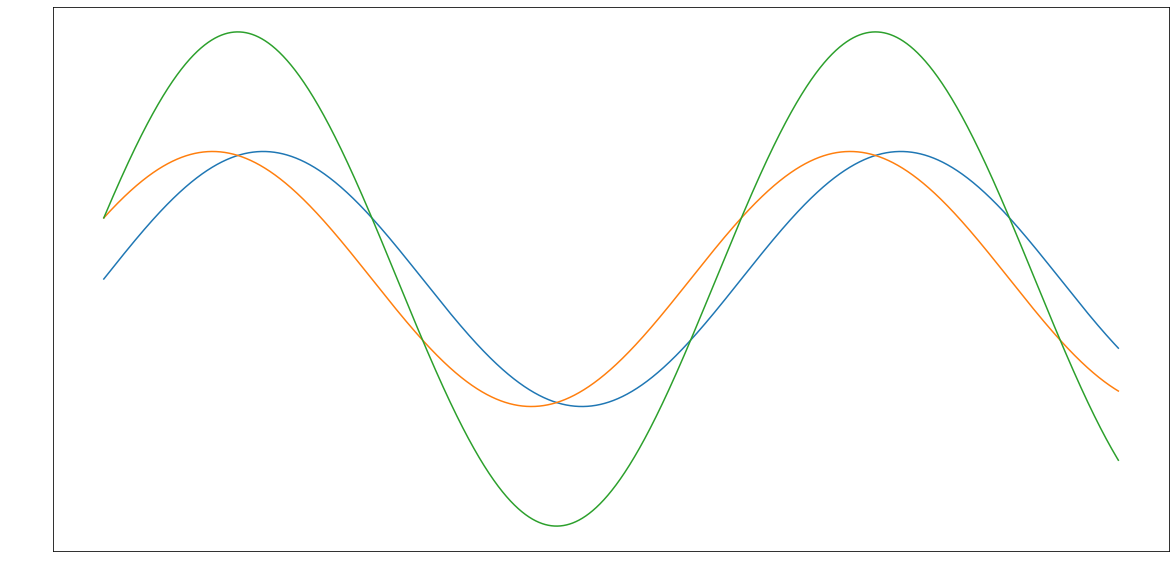

In [60]:
freq_i = 0.2
y1=np.sin(freq_i*x/100)
y2=np.sin((freq_i*x/100)+shift_x)
y_sum = y1+y2
plt.figure(figsize=(20,10))
plt.plot(x,y1)
plt.plot(x,y2)
plt.plot(x,y_sum)

### Isolated Points in K-space and Effects of Shift

In [207]:
k_0 = np.zeros((265,256),dtype = 'complex')
k_0_shift = np.zeros((265,256),dtype = 'complex')

k_mid = np.zeros((265,256),dtype = 'complex')
k_mid_shift = np.zeros((265,256),dtype = 'complex')

k_end = np.zeros((265,256),dtype = 'complex')
k_end_shift = np.zeros((265,256),dtype = 'complex')

# 2 points from consecutive Lines in the row of K-space within same Column
k_0[1:2,127] = k_sp[1:2,127]

# Row lines in which 
k_0_shift[1,127] = k_sp[1,127]
k_0_shift[2,127] = k_sp[4,127]


# 2 points from consecutive Lines in the row of K-space within same Column
k_mid[127:128,127] = k_sp[127:128,127]

# Row lines in which 
k_mid_shift[127,127] = k_sp[127,127]
k_mid_shift[128,127] = k_sp[129,127]


# 2 points from consecutive Lines in the row of K-space within same Column
k_end[244:255,127] = k_sp[244:255,127]

# Row lines in which 
k_end_shift[244,127] = k_sp[244,127]
k_end_shift[245,127] = k_sp[246,129]


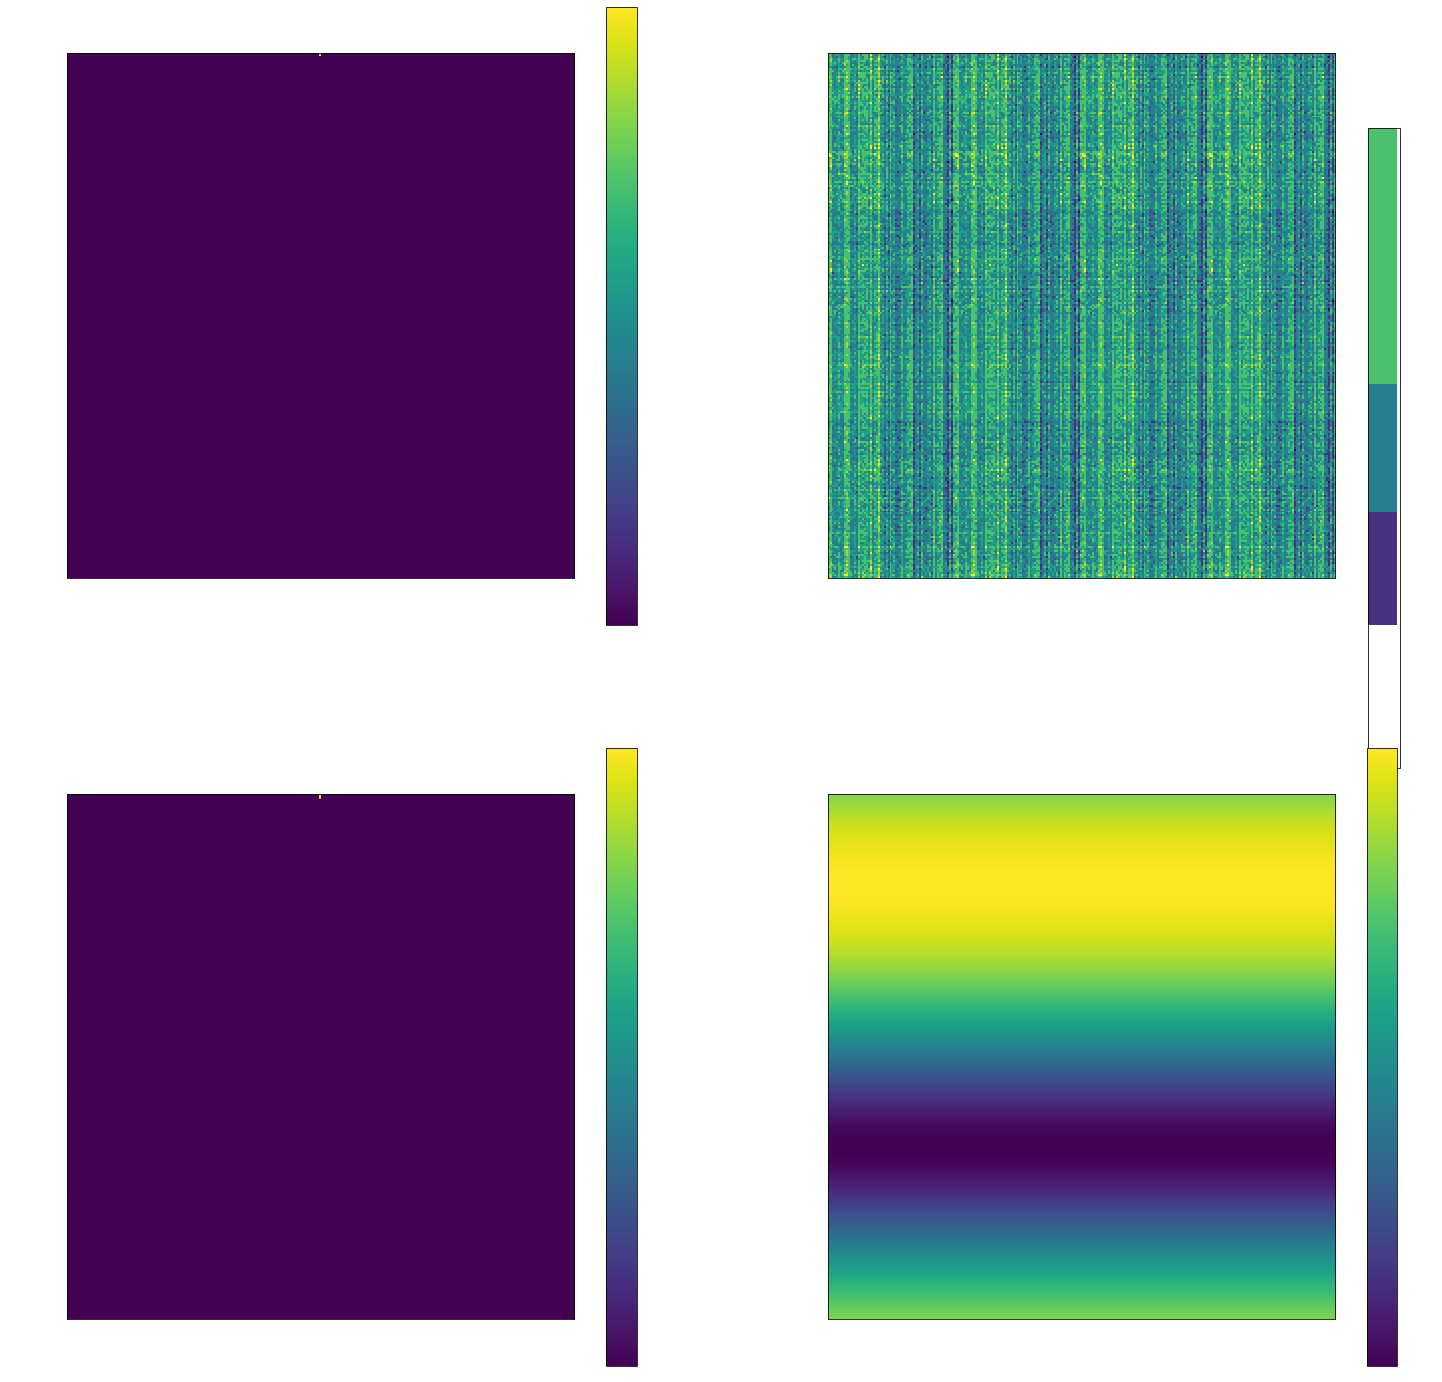

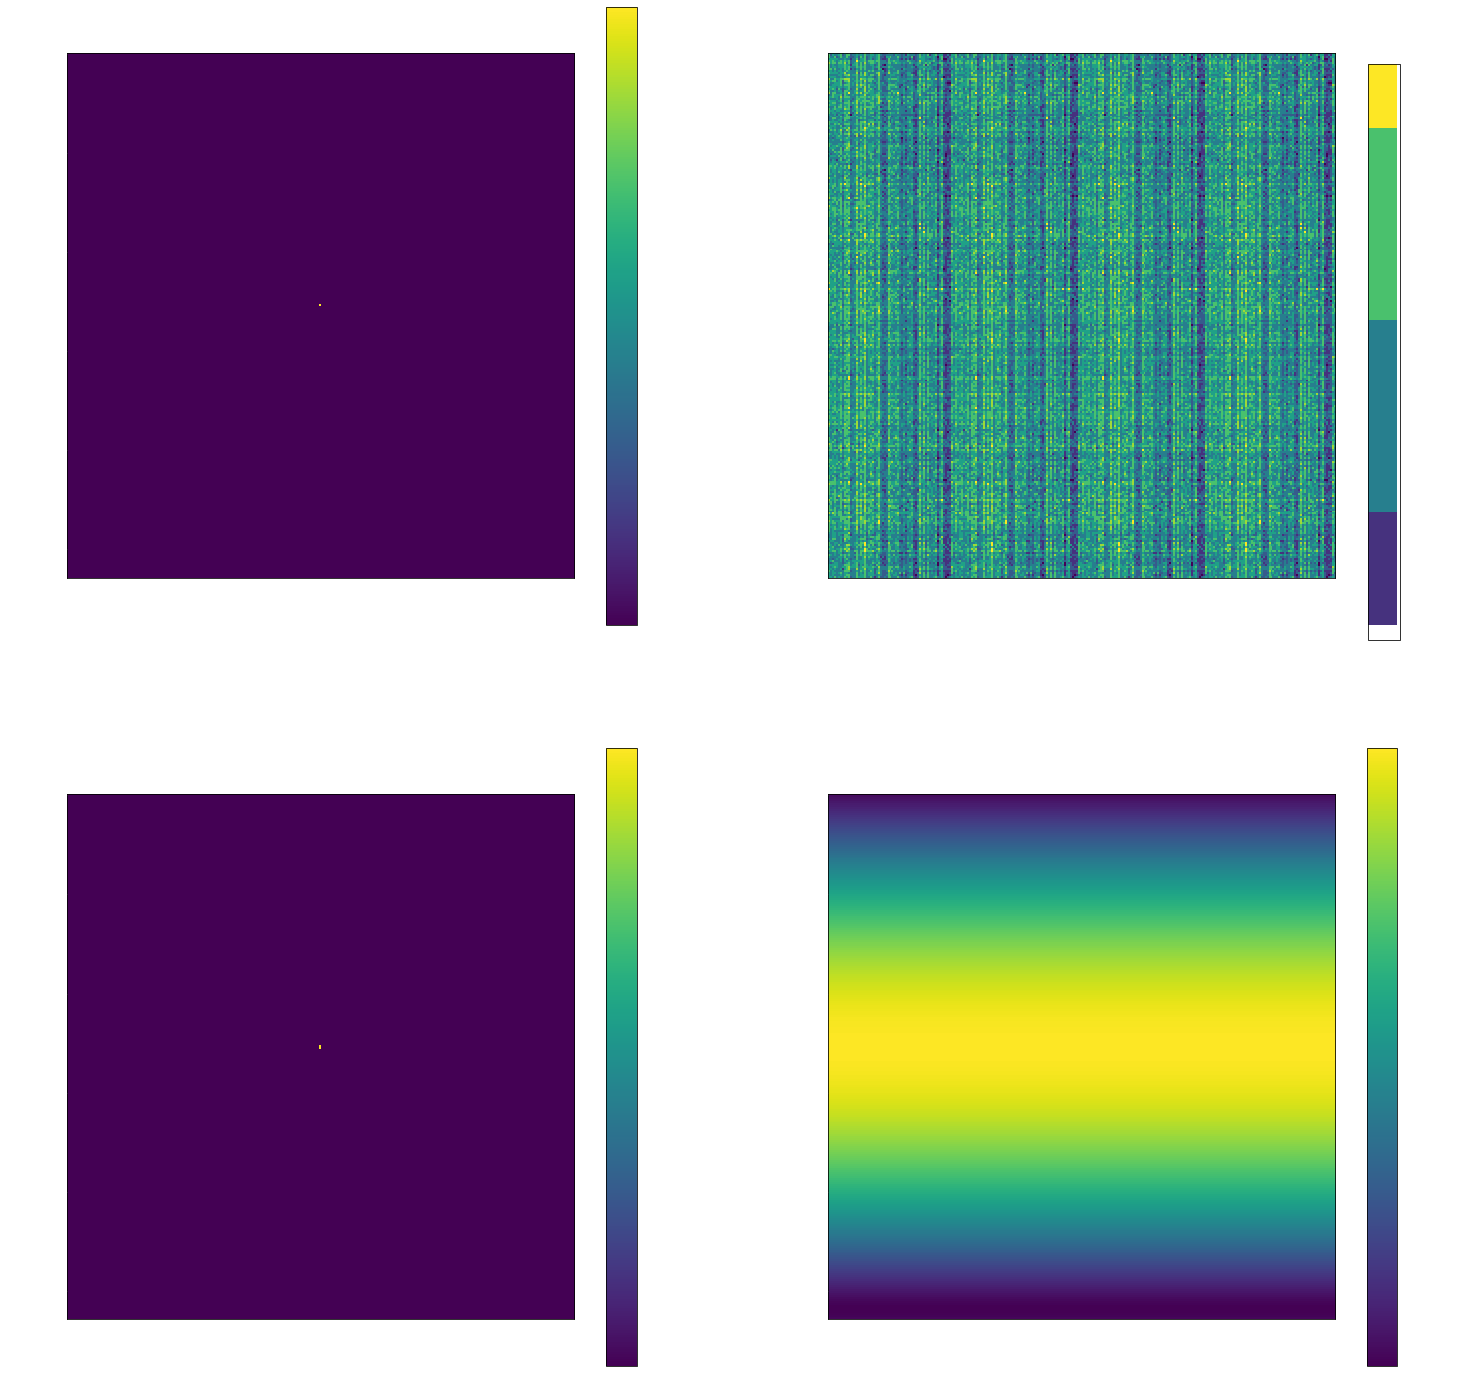

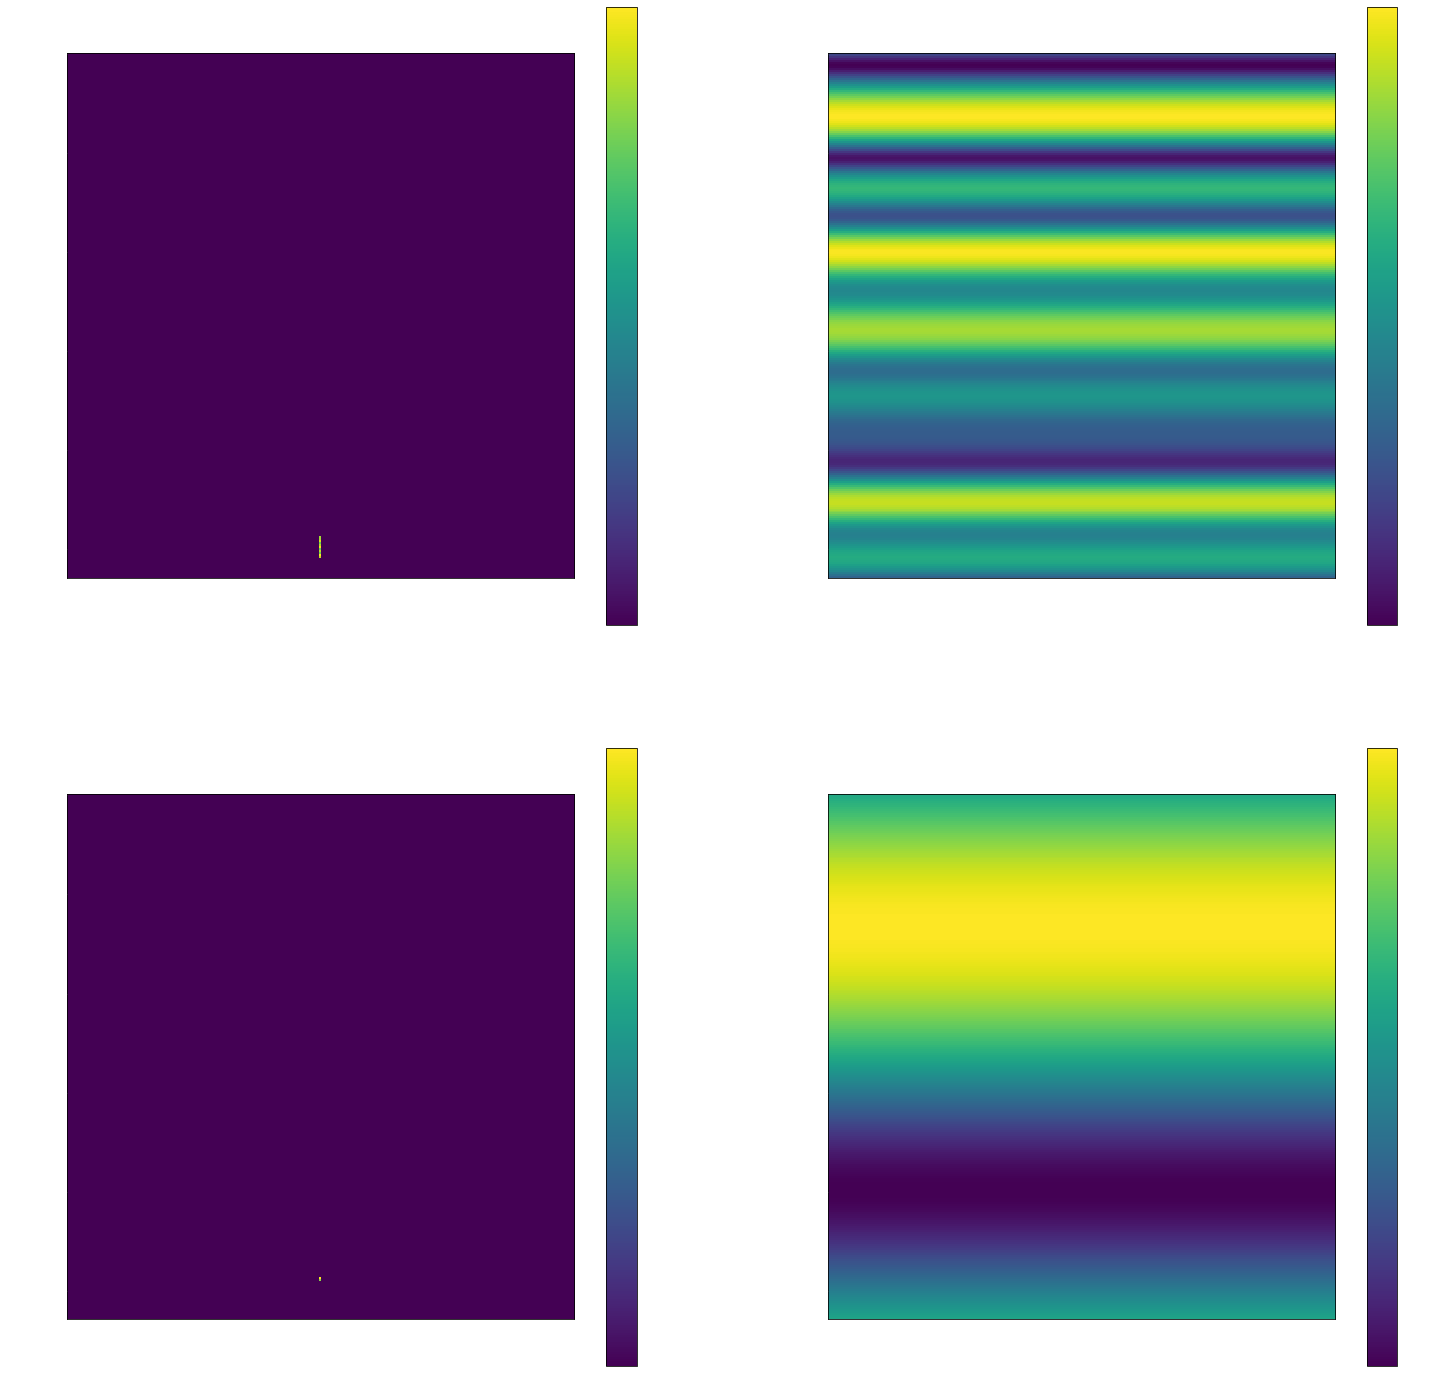

In [209]:
k_lines ={'Front k-space':k_0,
    'Front k-space Shift': k_0_shift
        }
k_lines2 ={'Mid k-space':k_mid,
    'Mid k-space Shift': k_mid_shift
        }

k_lines3 ={'End k-space':k_end,
    'End k-space Shift': k_end_shift
        }

plot.comparison_k_plots(k_lines)

plot.comparison_k_plots(k_lines2)

plot.comparison_k_plots(k_lines3)
